# LAB ASSIGNMENT 11 OF IMAGE SIGNAL PROCESSING

## Mansi Kakkar

## EE21S063

___

# Non-Blind Deblurring Using Gradient Regularization
____



## Importing Libraries

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

In [218]:
import matlab.engine
eng = matlab.engine.start_matlab()

## Reading Images


In [38]:
# Reading Images

lena = io.imread('lena.png');
mb_kernel = io.imread('mb-kernel.png');


In [73]:
lena.shape

(277, 277)

## Defining $q_x$ , $q_y$ and $h$

In [40]:
qx = [1, -1]
qy = [[1],[-1]]
h = mb_kernel/(np.sum(mb_kernel[:]))


## Intialising Values

In [169]:
#Initialisation

l_start = 0.01
l_end = 2.0
l_step = 0.01
n_lambdas = int(((l_end-l_start)/l_step)+1)
sigma_n = [8, 8, 8, 5, 10, 15]
sigma_b = [0.5, 1.0, 1.5, 1.0, 1.0, 1.0]
n = len(sigma_n)
print(n)
print(n_lambdas)
best_lambdas = np.zeros(n);
rmse_values = np.zeros((n, n_lambdas))
rmse_values.shape

6
200


(6, 200)

## Functions acting as Interface between Python and MATLAB

In [41]:
def npArray2Matlab(x):
    return matlab.double(x.tolist())
def matlabtopython(x):
    return np.asarray(x)

## Mean Square Error Function

In [85]:
# Mean Squared Error

def mean_squared_error(x, y):
    #x = np.float(x)
    #y = np.float(y)
    err = np.mean((x - y)**2)
    return err

## Gaussian Kernel

In [175]:
#GETTING KERNEL SIZE

def kernel_size(sigma):
    #defining window size
    size = np.ceil(6*sigma)+1
    print(rf"kernel size is {size}")
    #checking whether it is odd or not ; if not then incrementing the size to odd
    size = int(size)
    if size%2 == 0:
        size = size+1
    return size

In [112]:
# Gaussian Kernel

def gaussian_kernel(sigma):
    w = kernel_size(sigma)
    kernel = np.zeros((w,w))
    s_c = w//2
    
    #for condition where sigma is 0
    if w==1:
        kernel = np.ones((w, w))
        return kernel
    
    #defining kernel
    for x in range(w):
        for y in range(w):
            temp = np.exp((-((x-s_c)**2)-((y-s_c)**2))/(2*(sigma**2)))
            kernel[x,y] = temp / (2*np.pi*(sigma**2))
            
    #dividing by th sum of kernel
    kernel = kernel/np.sum(kernel)
    return kernel

## Gaussian Noise

In [113]:
# Gaussian Noise

def gaussian_noise(lena, sigma):
    row,col= np.shape(lena)
    mean = 0
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = lena + gauss
    return noisy

In [203]:
def zero_pad_image(image, pad_size):
    x, y = np.shape(image)
    padded_image = np.zeros((x+2*pad_size, y+2*pad_size))
    padded_image[pad_size:-pad_size, pad_size:-pad_size] = image
    return padded_image

## Finding Best Lambda Function

In [211]:
# Finding Best Lambda

def Best_Lambda(lena, sigma_n, sigma_b, l_start, l_end, l_step, qx, qy, is_gaussian_blur, norm):
    x,y = np.shape(lena)
    size = np.array((x,y))
    q_x = np.asarray(qx)
    q_y = np.asarray(qy)
    if not is_gaussian_blur:
        h = gaussian_kernel(sigma_b)
        H = matlabtopython(eng.psf2otf(npArray2Matlab(h), npArray2Matlab(size)))
    else:
        H = matlabtopython(eng.psf2otf(npArray2Matlab(sigma_b), npArray2Matlab(size)))
    Qx = matlabtopython(eng.psf2otf(npArray2Matlab(q_x), npArray2Matlab(size)))
    Qy = matlabtopython(eng.psf2otf(npArray2Matlab(q_y), npArray2Matlab(size)))
    noisy_image = degrade_image(lena, sigma_b, sigma_n, is_gaussian_blur)
    print(rf"best lambda noisy image is {noisy_image.shape}")
    lambda_values = np.arange(l_start, l_end+0.01, l_step)
    n_lambda = len(lambda_values)
    print(rf"n lambdas are {n_lambda}")
    rmse_values = np.zeros(np.size(lambda_values))
    lambda_best = l_start
    rmse_best = np.inf
    if norm == 'L1':
        print('Finding best lambda for L1 normalisation')
        for i in range(n_lambda):
            lambda_ = lambda_values[i]
            clean_image = matlabtopython(eng.admmfft(npArray2Matlab(noisy_image), 
                                                     npArray2Matlab(h), npArray2Matlab(lambda_), 1))
            rmse = mean_squared_error(clean_image, noisy_image)
            rmse_values[i] = rmse
            if rmse < rmse_best:
                rmse_best = rmse
                lambda_best = lambda_
            
    elif norm == 'L2':
        for i in range(n_lambda):
            lambda_ = lambda_values[i]
            G = np.fft.fft2(noisy_image)
            freq_trans = np.conj(H)/((np.abs(H))**2+lambda_*(np.abs(Qx)**2)+lambda_*(np.abs(Qy)**2))
            clean_image = np.abs(np.fft.ifft2(freq_trans*G))
            rmse = mean_squared_error(clean_image, noisy_image)
            rmse_values[i] = rmse
            if rmse < rmse_best:
                rmse_best = rmse
                lambda_best = lambda_
    return lambda_best, rmse_values 

## 2D Convolution

In [199]:
def Convolution_2d(image, kernel, conv_type='same', correlation=True):
    # get the shape of the image
    x, y = np.shape(image)
    # get the shape of the kernel
    # assumed that the kernel is a square matrix
    w = len(kernel)
    d = w//2
    # if the kernel is a single value, simply multiply and return
    if d == 0:
        filtered_image = kernel*image
    else:
        if not correlation:
            # flip the kernel if convolution is to be performed
            kernel = kernel[::-1, ::-1]
        if conv_type == 'valid':
            # no zero padding needed now
            filtered_image = np.zeros((x-2*d, y-2*d))
            for i in range(d, x-d):
                for j in range(d, y-d):
                    # extract image patch
                    patch = image[i-d:i+d+1, j-d:j+d+1]
                    # multiply image patch with the kernel, sum and store
                    filtered_image[i-d, j-d] = np.sum(patch*kernel)
        elif conv_type == 'same':
            # zero pad so that the output is of the same size
            padded_image = zero_pad_image(image, d)
            filtered_image = np.zeros((x, y))
            for i in range(d, x+d):
                for j in range(d, x+d):
                    # extract image patch
                    patch = padded_image[i-d:i+d+1, j-d:j+d+1]
                    # multiply image patch with the kernel, sum and store
                    filtered_image[i-d, j-d] = np.sum(patch*kernel)
        else:
            # if the convolution type is not understood, i.e., it is not one
            # of 'same' or 'valid', just return the original image
            filtered_image = image
    return filtered_image

## Degrading Image Function

In [200]:
# Degrading Image Function

def degrade_image(lena, sigma_b, sigma_n, is_gaussian_blur):
    image = lena/255.0
    print(rf"image shape is {image.shape}")
    sigma_n= sigma_n/255.0
    print(rf"sigma b is {sigma_b}")
#    img = zero_padded_image(image, 0)
    img = image.copy()
    print(rf"image shape is {img.shape}")    
    if not is_gaussian_blur:
        blur_kernel = gaussian_kernel(sigma_b)
        print(rf"blur kernel shape is {blur_kernel.shape}")
        blurred_image = Convolution_2d(img, blur_kernel)
        degraded_image = gaussian_noise(blurred_image, sigma_n)
    else:
        blurred_image = Convolution_2d(img, sigma_b)
        print(rf"blurred image shape is {blurred_image.shape}")
        degraded_image = gaussian_noise(blurred_image, sigma_n)
    print(rf"degrade_image noisy image{degraded_image.shape}")
    return degraded_image

## Deblurring

In [239]:
def deblur(g, sigma_b, lambda_, qx, qy, is_motion_blur, norm):
    
    if norm == 'L1':
        if not is_motion_blur:
            h = gaussian_kernel(sigma_b)
            #l = np.asarray(lambda_)
            s_b = np.asarray(sigma_b)
            clean_image = matlabtopython(eng.admmfft(npArray2Matlab(g), 
                                                     npArray2Matlab(h), lambda_, 1))
        else:
            clean_image = matlabtopython(eng.admmfft(npArray2Matlab(g), 
                                                     npArray2Matlab(s_b), npArray2Matlab(l), 1))
    elif norm == 'L2':
        
        x, y = np.shape(g)
        size = np.array((x,y))
        q_x = np.asarray(qx)
        q_y = np.asarray(qy)
        if not is_motion_blur:
            h = gaussian_kernel(sigma_b);
            H = matlabtopython(eng.psf2otf(npArray2Matlab(h), npArray2Matlab(size)))
        else:
            H = matlabtopython(eng.psf2otf(npArray2Matlab(sigma_b), npArray2Matlab(size)))
        Qx = matlabtopython(eng.psf2otf(npArray2Matlab(q_x), npArray2Matlab(size)))
        Qy = matlabtopython(eng.psf2otf(npArray2Matlab(q_y), npArray2Matlab(size)))
        G = np.fft.fft2(g)
        freq_trans = np.conj(H)/(np.abs(H)**2+lambda_*(np.abs(Qx)**2)+lambda_*(np.abs(Qy)**2))
        clean_image = np.abs(np.fft.ifft2(freq_trans*G))
        
    return clean_image

# RESULTS

n is6
i is 0
result sigma b is0.5
kernel size is 4.0
image shape is (277, 277)
sigma b is 0.5
image shape is (277, 277)
kernel size is 4.0
blur kernel shape is (5, 5)
degrade_image noisy image(277, 277)
best lambda noisy image is (277, 277)
n lambdas are 200
image shape is (277, 277)
sigma b is 0.5
image shape is (277, 277)
kernel size is 4.0
blur kernel shape is (5, 5)
degrade_image noisy image(277, 277)


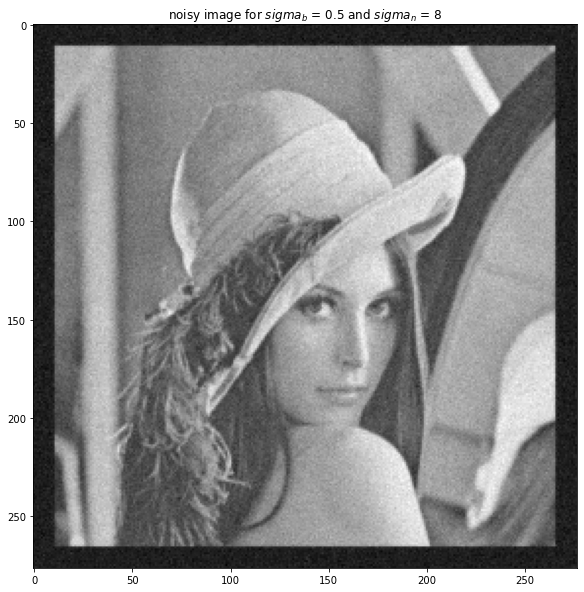

kernel size is 4.0


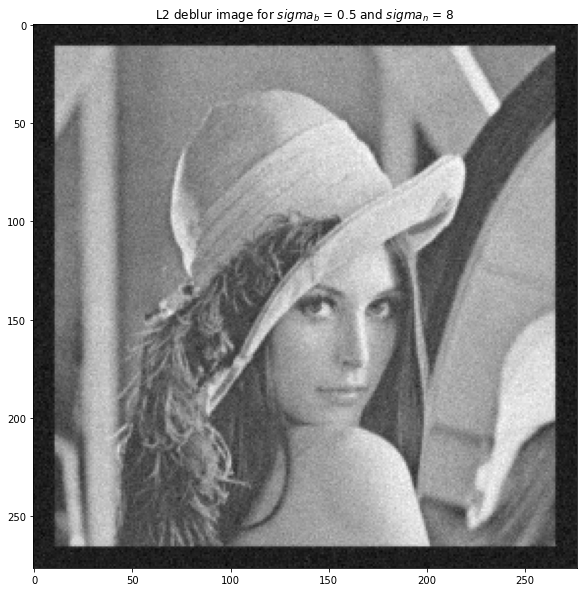

kernel size is 4.0


TypeError: unsupported Python data type: numpy.float64

In [240]:
# Results
print(rf"n is{n}")
for i in range(n):
    print(rf"i is {i}")
    s_n = sigma_n[i]
    s_b = sigma_b[i]
    print(rf"result sigma b is{s_b}")
    [best_l, rmse_i] = Best_Lambda(lena, s_n, s_b, l_start, l_end, l_step, qx, qy, False,'L2')
    best_lambdas[i] = best_l
    rmse_values[i,:] = rmse_i
    #noisy image
    noisy_image = degrade_image(lena, s_b, s_n, False)
    plt.figure(figsize = (10,10))
    plt.title(rf'noisy image for $sigma_b$ = {s_b} and $sigma_n$ = {s_n}')
    plt.imshow(noisy_image,'gray')
    plt.show()
    #debluring L2
    deblur(noisy_image, s_b, best_l, qx, qy, False, 'L2')
    plt.figure(figsize = (10,10))
    plt.title(rf'L2 deblur image for $sigma_b$ = {s_b} and $sigma_n$ = {s_n}')
    plt.imshow(noisy_image,'gray')
    plt.show()
    #debluring L1
    deblur(noisy_image, s_b, best_l, qx, qy, False, 'L1')
    plt.figure(figsize = (10,10))
    plt.title(rf'L1 deblur image for $sigma_b$ = {s_b} and $sigma_n$ = {s_n}')
    plt.imshow(noisy_image,'gray')
    plt.show()
    


In [ ]:
eng.quit()